In [15]:
import glob
import os
import numpy as np
import struct
import matplotlib.pyplot as plt; plt.ion()
import json
import pandas as pd
import matplotlib.patches as patches

ping_width_ms=27
ping_min_snr=14
ping_max_len_mult=1.5
ping_min_len_mult=0.5
frequencies=173965000
sampling_freq=1500000
center_freq = 173500000
FFT_LEN = 2048

target_freqs = np.array([173965000])
target_freqs = ((target_freqs - center_freq) / (sampling_freq / 2) * FFT_LEN /2).astype(np.int)

numSamples = 64*1024*1024/4

int_time_s = 6e-3
int_factor = int(int_time_s * sampling_freq / FFT_LEN)
clfr_input_freq = sampling_freq / int_factor / FFT_LEN
maximizer_len = int(0.1 * clfr_input_freq)
median_len = int(1 * clfr_input_freq)
ping_width_samp = ping_width_ms / 1000. * sampling_freq / FFT_LEN / int_factor
data_len = ping_width_samp * 2
id_len = clfr_input_freq * 0.5
_ms_per_sample = 1/(sampling_freq / int_factor / FFT_LEN) * 1e3
print(int_factor)
print(maximizer_len)
print(median_len)

4
18
183


In [2]:
files = sorted(glob.glob('**/RAW_DATA*', recursive=True))

In [16]:
run_num = 481
localizeFilePath = 'RUN_%06d/LOCALIZE_%06d' % (run_num, run_num)
metaFilePath = 'RUN_%06d/META_%06d' % (run_num, run_num)
pingNum = 10

pings = []
with open(localizeFilePath) as localizeFile:
    for line in localizeFile:
        packet = json.loads(line)
        if 'ping' in packet:
            pings.append(packet['ping'])
start_time = 0;
with open(metaFilePath) as metaFile:
    for line in metaFile:
        if 'start_time' in line.split(': '):
            start_time = float(line.split(': ')[1].strip())

df = pd.DataFrame(pings)
df['lat'] /= 1e7
df['lon'] /= 1e7
df['time'] /= 1e3
df['time'] -= start_time
fileIdx = df.iloc[pingNum]['time'] * sampling_freq / numSamples
fileNum = int(fileIdx)
fileOffset = (fileIdx % 1) * numSamples / sampling_freq

In [17]:
file = "RUN_%06d/RAW_DATA_%06d_%06d" % (run_num, run_num, fileNum)
with open(file, 'rb') as datafile:
    fileContent = datafile.read()
fileSize = len(fileContent)

rawsamples = [struct.unpack('hh', fileContent[4*i:4*i+4]) for i in range(int(numSamples))]
samples = np.array([sample[0] + sample[1] * 1j for sample in rawsamples]) / np.iinfo(np.int16).max
fileTime = numSamples / sampling_freq

In [18]:
fft_in = np.reshape(samples, (2048, int(numSamples / 2048)))
fft_out = np.fft.fft(fft_in, axis=0)

In [19]:
shp = fft_out.shape
shp = shp[0], int(shp[1] / int_factor)
integrated_data = np.zeros(shp)
power_data = np.power(np.abs(fft_out), 2)
for i in range(shp[1]):
    integrated_data[:,i] = np.sum(power_data[:,int_factor * i:int_factor * (i + 1)])

In [20]:
targetData = integrated_data[target_freqs[0],:]
peak_history = np.zeros(len(targetData) - maximizer_len)
for i in range(len(peak_history)):
    peak_history[i] = np.max(targetData[i:i+maximizer_len])
threshold = np.zeros(len(peak_history) - median_len)
for i in range(len(threshold)):
    threshold[i] = np.median(peak_history[i:i+median_len])
threshold = threshold + ping_min_snr

alt     0.000000e+00
amp     2.809500e+02
lat     3.288459e+01
lon    -1.172337e+02
time    5.779100e+01
txf     1.735000e+08
Name: 10, dtype: float64


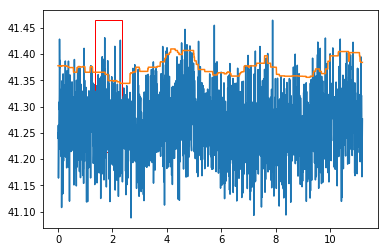

In [23]:
fig1, ax = plt.subplots(1)
plt.plot(np.arange(0, fileTime, fileTime / len(integrated_data[target_freqs[0],:])), 10*np.log10(integrated_data[target_freqs[0],:]))
plt.plot(np.arange(0, fileTime, fileTime / len(threshold)), 10*np.log10(threshold))
rect = patches.Rectangle((fileOffset-0.5, 10*np.log10(np.max(integrated_data[target_freqs[0],:]))), 1, -.25, linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.savefig('test.png')
print(df.iloc[pingNum])

In [22]:
fileOffset

1.866946794459025

In [10]:
targetData.shape

(2048,)

In [11]:
np.arange(0, fileTime, fileTime / len(integrated_data))

array([0.00000000e+00, 5.46133333e-03, 1.09226667e-02, ...,
       1.11684267e+01, 1.11738880e+01, 1.11793493e+01])

In [12]:
len(integrated_data)

2048

In [13]:
run_num

481